# Learning the coarse-grained variable from data
#### from "Particles to PDEs parsimoniously" by Arbabi & Kevrekidis 2020

H. Arbabi, arbabiha@gmail.com
October 2020

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import timeit

from matplotlib.patches import Ellipse, Rectangle
from matplotlib import lines

import unbalanced_transport as UT
from scipy.spatial.distance import pdist, squareform,cdist
import mydiffusion_maps as DM

import BurgersGapTooth as BGT
import importlib

from scipy.optimize import curve_fit


%matplotlib inline


In [2]:
# load data (should have run Gap-tooth simulation already)
filename = 'BurgersGT_Z500k_N128_n12.npz'
Data = np.load(filename)
x,t,rho = Data['x'],Data['t'],Data['Density']
teeth_histograms = Data['teeth_histograms']
rho0s=Data['rho0s']


We choose a snapshot of data for learning.
We pick one that has a large variance of density so that we can later extend to other snapshots.

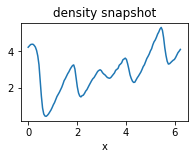

In [3]:
v_rho = np.var(rho,axis=-1)
maxv = np.unravel_index(np.argmax(v_rho),v_rho.shape)

itraj,snapshot = 2,100

plt.figure(figsize=[3,1.8])
plt.plot(x,rho[itraj,snapshot])
plt.xlabel('x'),plt.title('density snapshot')

distributions = teeth_histograms[itraj,snapshot]


## Distance of distributions

### 1- Unnormalized Optimal Transport by Gangbo et al 2019

In [4]:
# very fast (analytic formula)

# normalize (arbitrary)
scaling = np.max(distributions)
distributions = distributions/scaling

dw_fun = lambda u,v:UT.unbalanced_Wasserstein_L1(u,v,alpha=1)
d_W = squareform(pdist(distributions,metric=dw_fun))


### 2- Unbalanced optimal transport by Chizat et al 2018

In [5]:
# slow (takes ~ 30 min)

N = distributions.shape[1] # number of bins in histogram

row = np.arange(0,N)
c= linalg.toeplitz(row)/(N**2) # cost matrix

epsilon = 1e-3
options={'rho':1.0}

WFR_distance_fun=lambda u,v: UT.sinkhorn_log(u,v,c,epsilon,options)[-1]

ttin = timeit.default_timer()
d_U = squareform(pdist(distributions,metric=WFR_distance_fun))
print('whole run took {} seconds'.format(timeit.default_timer() - ttin))


whole run took 492.50148522807285 seconds


### 3- Moments distance

In [6]:
def compute_moment_vector(hist,orders=np.arange(0,8),x=None):
    """Computing vector of moments for a histogram.
    
    Args:
        hist: the vector of histogram values
        orders: order of the moment
        x: coordiantes of bin centers for histogram
    
    Returns:
        vector of moments
    """
    Moments = np.zeros(orders.shape[0])
    
    for j,a in enumerate(orders):
        if x is None:
            x = np.arange(0,hist.size)/hist.size
            dx = x[1]-x[0]
        Moments[j] = np.sum(hist* (x**a)) * dx
    
    return Moments

moment_reps= np.apply_along_axis(compute_moment_vector,-1,distributions)


# rescale to max1
moment_reps_normalized = moment_reps/np.max(moment_reps,axis=0)

d_M = squareform(pdist(moment_reps,metric='sqeuclidean'))

moment_reps.shape

(128, 8)

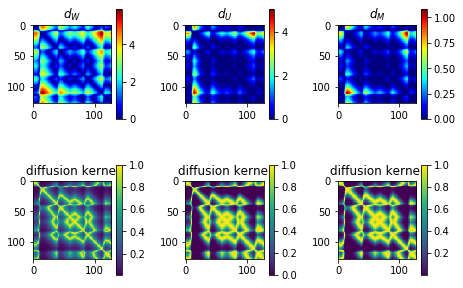

In [7]:
fig=plt.figure(figsize=[6.5,4.5])

ax = plt.subplot(2,3,1)
ax.set_title('$d_W$', fontsize=12)
ax1=ax.imshow(d_W,cmap='jet')
cbar=fig.colorbar(ax1, ax=ax,shrink=.8)

eps=np.median(d_W)
W=np.exp(-d_W/eps)
ax = plt.subplot(2,3,4)
ax.set_title('diffusion kernel', fontsize=12)
ax1=ax.imshow(W)
cbar=fig.colorbar(ax1, ax=ax,shrink=.8)


if 'd_U' in locals():
    ax = plt.subplot(2,3,2)
    ax.set_title('$d_U$', fontsize=12)
    ax1=ax.imshow(d_U,cmap='jet')
    cbar=fig.colorbar(ax1, ax=ax,shrink=.8)

    eps=np.median(d_U)
    W=np.exp(-d_U/eps)
    ax = plt.subplot(2,3,5)
    ax.set_title('diffusion kernel', fontsize=12)
    ax1=ax.imshow(W)
    cbar=fig.colorbar(ax1, ax=ax,shrink=.8)

ax = plt.subplot(2,3,3)
ax.set_title('$d_M$', fontsize=12)
ax1=ax.imshow(d_M,cmap='jet')
cbar=fig.colorbar(ax1, ax=ax,shrink=.8)


eps=np.median(d_M)
W=np.exp(-d_M/eps)
ax = plt.subplot(2,3,6)
ax.set_title('diffusion kernel', fontsize=12)
ax1=ax.imshow(W)
cbar=fig.colorbar(ax1, ax=ax,shrink=.8)

plt.tight_layout()

# Diffusion Map equipped with Unnormalized Distance

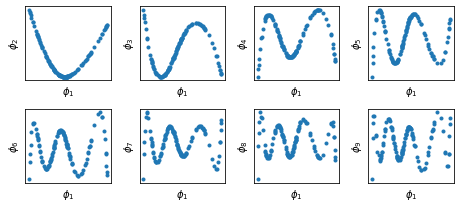

In [8]:
Manifold=DM.Manifold_Model(distributions,dw_fun)
phis,lams=Manifold.compute_diffusion_maps()


plt.figure(figsize=[6.5,3])
for i in range(2,10):
    plt.subplot(2,4,i-1)
    plt.plot(phis[:,1],phis[:,i],'.')
    plt.xlabel('$\phi_1$')
    plt.ylabel('$\phi_'+str(i)+'$')
    plt.xticks([]),plt.yticks([])
plt.tight_layout()


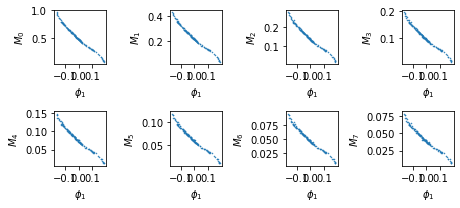

In [9]:
# data-driven variables vs moments
plt.figure(figsize=[6.5,3])
for i in range(0,8):
    plt.subplot(2,4,i+1)
    plt.plot(phis[:,1],moment_reps[...,i],'.',markersize=1)
    plt.xlabel('$\phi_1$')
    plt.ylabel('$M_'+str(i)+'$')

plt.tight_layout()


### regression of $\phi(\rho)$

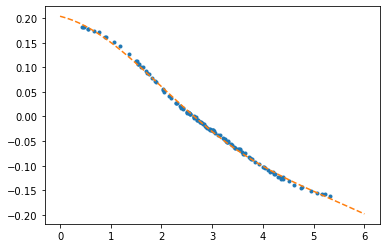

In [10]:
phi1 = phis[:,1]
rho1 = rho[itraj,snapshot]


# a very simple regressor, once can use NN, SVM etc
def func(x, a, b, c, d, e):
    y = a + b*x + c*x**2 + d * x**3 + e* np.cos(2*np.pi*x/6)
    return y

popt, pcov = curve_fit(func, rho1, phi1)


rho_test = np.linspace(0,6)
plt.figure()
plt.plot(rho1,phi1,'.')
plt.plot(rho_test,func(rho_test,*popt),'--')

In [11]:
# extend to all data
phi_data=func(rho,*popt)


In [12]:
# save the data
np.savez(filename[:-4]+'_phi.npz',x=x,t=t,
         Density=rho,phi=phi_data,rho0s=rho0s,
        nu = Data['nu'],popt=popt)
